In [2]:
!pip install transformers
!pip install datasets

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
# !pip install --upgrade --force-reinstall --no-deps transformers
# !pip install --upgrade --force-reinstall --no-deps datasets

# !pip install --upgrade --force-reinstall --no-deps huggingface_hub

# !pip install --upgrade --force-reinstall --no-deps pyarrow

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
from datasets import load_dataset,DatasetDict

c:\Users\qasim\anaconda3\envs\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
DATA_PATH = "labeled_data.csv" # In Colab


In [7]:
# pandas_df = pd.read_csv("labeled_data.csv")
pandas_df = pd.read_csv(DATA_PATH)
pandas_df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
import seaborn as sns
sns.countplot(data=pandas_df, x="class")


ModuleNotFoundError: No module named 'seaborn'

In [9]:
pandas_df['tweet_cleaned'] = pandas_df['tweet'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
pandas_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet_cleaned
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,!!!!!!!!! RT _G_Anderson: _based she look like...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,!!!!!!!!!!!!! RT : The shit you hear about me ...


In [10]:
from datasets import Dataset

ds = Dataset.from_pandas(pandas_df)
ds

Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'tweet_cleaned'],
    num_rows: 24783
})

In [11]:

dataset = load_dataset('csv', data_files=DATA_PATH, split='train')

dataset

Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet'],
    num_rows: 24783
})

In [12]:
train_test_valid = ds.train_test_split()

test_valid = train_test_valid['test'].train_test_split()

train_test_valid_dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
    })


dataset = train_test_valid_dataset.remove_columns(['hate_speech', 'offensive_language', 'neither','Unnamed: 0', 'count'])
dataset


DatasetDict({
    train: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 1549
    })
    valid: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 4647
    })
})

In [13]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [14]:
text = "Just checking tokenization"

output = tokenizer(text)

output

{'input_ids': [101, 2066, 9444, 22559, 2734, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [15]:
tokens = tokenizer.convert_ids_to_tokens(output['input_ids'])
tokens

['[CLS]', 'Just', 'checking', 'token', '##ization', '[SEP]']

In [16]:
print(f"Tokenized text: {tokenizer.convert_tokens_to_string(tokens)}")

Tokenized text: [CLS] Just checking tokenization [SEP]


In [17]:
print(f"Vocab size is : {tokenizer.vocab_size}")

print(f"Model max length is : {tokenizer.model_max_length}")

print(f"Model input names are: {tokenizer.model_input_names}")

Vocab size is : 28996
Model max length is : 512
Model input names are: ['input_ids', 'token_type_ids', 'attention_mask']


In [18]:
ds

Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'tweet_cleaned'],
    num_rows: 24783
})

In [19]:
def tokenize_function(train_dataset):
    return tokenizer(train_dataset['tweet_cleaned'], padding='max_length', truncation=True)


tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenized_dataset

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['valid']
test_dataset = tokenized_dataset['test']

Map:   0%|          | 0/18587 [00:00<?, ? examples/s]

Map: 100%|██████████| 4647/4647 [00:00<00:00, 5233.30 examples/s]


In [20]:
train_dataset

Dataset({
    features: ['class', 'tweet', 'tweet_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 18587
})

In [21]:
train_set = train_dataset.remove_columns(['tweet', "tweet_cleaned"]).with_format('tensorflow')

tf_eval_dataset = eval_dataset.remove_columns(['tweet', "tweet_cleaned"]).with_format('tensorflow')

tf_test_dataset = test_dataset.remove_columns(['tweet', "tweet_cleaned"]).with_format('tensorflow')

In [22]:
train_features = { x: train_set[x] for x in tokenizer.model_input_names  }

train_set_for_final_model = tf.data.Dataset.from_tensor_slices((train_features, train_set['class'] ))

train_set_for_final_model = train_set_for_final_model.shuffle(len(train_set)).batch(8)


eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
val_set_for_final_model = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset["class"]))
val_set_for_final_model = val_set_for_final_model.batch(8)

test_features = {x: tf_test_dataset[x] for x in tokenizer.model_input_names}
test_set_for_final_model = tf.data.Dataset.from_tensor_slices((test_features, tf_test_dataset["class"]))
test_set_for_final_model =test_set_for_final_model.batch(8)

In [23]:
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)
# model = TFAutoModelForSequenceClassification.from_pretrained("/mnt/e0ccdbdb-22c3-4d9b-9413-fd976a2e99ae/M1/Code_Org/HF_Models/bert-base-uncased", num_labels=3)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
history = model.fit(train_set_for_final_model, validation_data=val_set_for_final_model, epochs=8)

Epoch 1/8
2324/2324 [==============================] - 1463s 624ms/step - loss: 0.3397 - sparse_categorical_accuracy: 0.8892 - val_loss: 0.2709 - val_sparse_categorical_accuracy: 0.9120
Epoch 2/8
2324/2324 [==============================] - 1466s 631ms/step - loss: 0.2815 - sparse_categorical_accuracy: 0.9049 - val_loss: 0.3120 - val_sparse_categorical_accuracy: 0.8776
Epoch 3/8
2324/2324 [==============================] - 1466s 631ms/step - loss: 0.2500 - sparse_categorical_accuracy: 0.9115 - val_loss: 0.2540 - val_sparse_categorical_accuracy: 0.9141
Epoch 4/8
2324/2324 [==============================] - 1466s 631ms/step - loss: 0.2485 - sparse_categorical_accuracy: 0.9172 - val_loss: 0.2789 - val_sparse_categorical_accuracy: 0.8971
Epoch 5/8
2324/2324 [==============================] - 1466s 631ms/step - loss: 0.2178 - sparse_categorical_accuracy: 0.9234 - val_loss: 0.2751 - val_sparse_categorical_accuracy: 0.9133
Epoch 6/8
2324/2324 [==============================] - 1466s 631ms/ste

In [31]:
model.save('saved_model/my_model', save_format='tf')
print("Model saved in TensorFlow SavedModel format.")


INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets


Model saved in TensorFlow SavedModel format.


In [32]:
from tensorflow.keras.models import load_model

model = load_model('saved_model/my_model')
print("Model loaded successfully.")


Model loaded successfully.


In [33]:
model.save_weights('model_weights.h5')
print("Weights saved in HDF5 format.")


Weights saved in HDF5 format.


In [ ]:
# Assuming you have the model architecture defined
model.load_weights('model_weights.h5')
print("Weights loaded successfully into the model.")


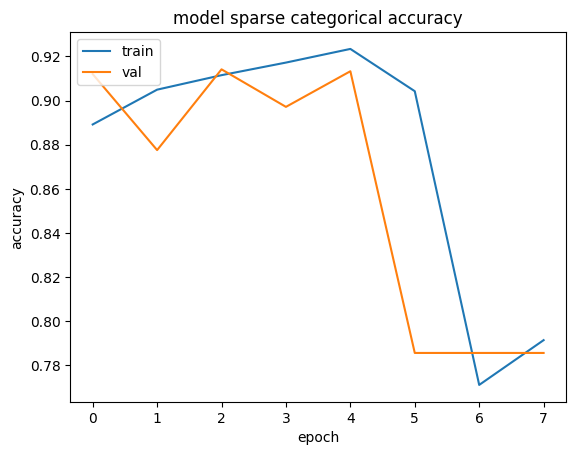

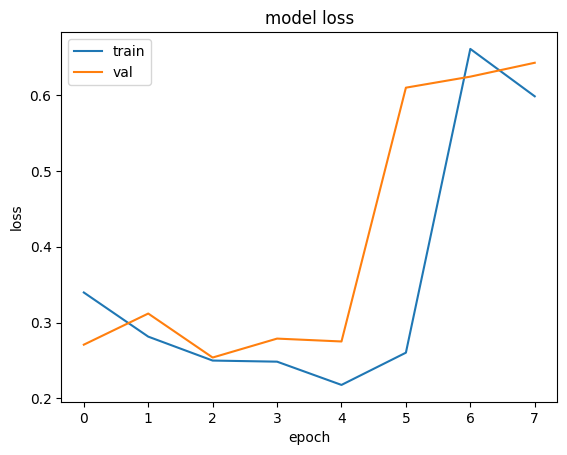

In [25]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model sparse categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
test_loss, test_acc = model.evaluate(test_set_for_final_model,verbose=2)
print('\nTest accuracy:', test_acc)

194/194 - 37s - loss: 0.6584 - sparse_categorical_accuracy: 0.7773 - 37s/epoch - 190ms/step

Test accuracy: 0.7772756814956665


In [28]:
# Dictionary to map class indices to class names
predict_score_and_class_dict = {
    0: 'Hate Speech',
    1: 'Offensive Language',
    2: 'Neither'
}

# Example texts
texts = ["He is useless, I dont know why he came to our neighbourhood", "That guy sucks", "He is such a retard"]

# Tokenizing and predicting
inputs = tokenizer(texts, return_tensors="tf", padding=True, truncation=True)
preds = model(inputs)['logits']

print(preds)

# Determining the class with the highest score
class_preds = np.argmax(preds, axis=1)

# Printing the class names
for pred in class_preds:
    print(predict_score_and_class_dict[pred])

tf.Tensor(
[[-0.95208156  1.3477958  -0.09526559]
 [-0.9520897   1.347809   -0.09525137]
 [-0.95206845  1.3478019  -0.09525175]], shape=(3, 3), dtype=float32)
Offensive Language
Offensive Language
Offensive Language


In [29]:
predict_score_and_class_dict = {0: 'Hate Speech',
 1: 'Offensive Language',
 2: 'Neither'}
preds = model(tokenizer(["He dresses up like a begger thise days"],return_tensors="tf",padding=True,truncation=True))['logits']
print(preds)
class_preds = np.argmax(preds, axis=1)

for pred in class_preds:
  print(predict_score_and_class_dict[pred])

tf.Tensor([[-0.9520855   1.3478085  -0.09524419]], shape=(1, 3), dtype=float32)
Offensive Language
